In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [2]:
batch_size = 100
original_dim = 784  # Height X Width
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1

In [3]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### Defining the encoder

In [4]:
# input to our encoder
x = Input(shape=(original_dim, ), name="input")

# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)

# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)

# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

### Defining the decoder

In [5]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim, ), name="decoder_input")

# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu',
                  name="decoder_h")(input_decoder)

# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid',
                  name="flat_decoded")(decoder_h)

# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


### Defining the Variational Autoencoder (VAE)

In [6]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [7]:
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
                       axis=-1)
vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 201988      input[0][0]                      
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          202256      encoder[0][2]                    
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
______________________________________________________________________________________________

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [9]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 17s 4ms/step - loss: 0.2823
Epoch 2/50
600/600 [==============================] - 2s 4ms/step - loss: 0.2190
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2134
Epoch 4/50
600/600 [==============================] - 2s 4ms/step - loss: 0.2110
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2082
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2067
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2048
Epoch 8/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2035
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2026
Epoch 10/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2012
Epoch 11/50
600/600 [==============================] - 2s 4ms/step - loss: 0.2001
Epoch 12/50
600/600 [==============================] - 2s 4ms/step - loss: 0.1995
Epoch 13/50
600/600 [===

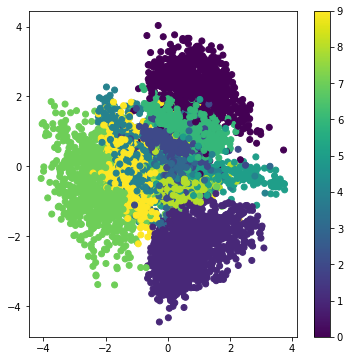

In [10]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0],
            x_test_encoded[:, 1],
            c=y_test,
            cmap='viridis')
plt.colorbar()
plt.show()

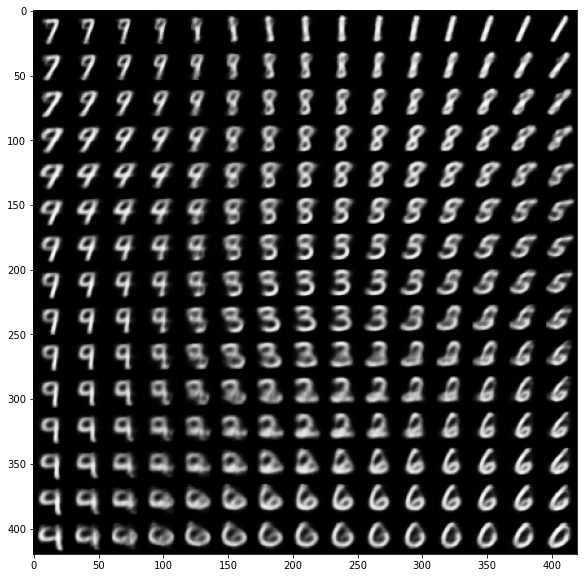

In [11]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size:(i + 1) * digit_size,
               j * digit_size:(j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()